In [12]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

In [13]:
import sys

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
src_path = os.path.join(project_root, "src")

if src_path not in sys.path:
    sys.path.append(src_path)

In [14]:
data_dir_path = os.path.join("..", "data", "gridloss", "train.csv")
df = pd.read_csv(data_dir_path, index_col=0)
df.index = pd.to_datetime(df.index)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17520 entries, 2017-12-01 00:00:00 to 2019-11-30 23:00:00
Data columns (total 38 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   demand                     17518 non-null  float64
 1   grid1-load                 17520 non-null  float64
 2   grid1-loss                 17519 non-null  float64
 3   grid1-loss-prophet-daily   16775 non-null  float64
 4   grid1-loss-prophet-pred    16775 non-null  float64
 5   grid1-loss-prophet-trend   16775 non-null  float64
 6   grid1-loss-prophet-weekly  16775 non-null  float64
 7   grid1-loss-prophet-yearly  16775 non-null  float64
 8   grid1-temp                 17518 non-null  float64
 9   grid2-load                 17520 non-null  float64
 10  grid2-loss                 17519 non-null  float64
 11  grid2-loss-prophet-daily   16775 non-null  float64
 12  grid2-loss-prophet-pred    16775 non-null  float64
 13  grid2-loss-

In [15]:
# Backfill missing data
df = df.bfill()

print(df.isnull().sum())

demand                       0
grid1-load                   0
grid1-loss                   0
grid1-loss-prophet-daily     0
grid1-loss-prophet-pred      0
grid1-loss-prophet-trend     0
grid1-loss-prophet-weekly    0
grid1-loss-prophet-yearly    0
grid1-temp                   0
grid2-load                   0
grid2-loss                   0
grid2-loss-prophet-daily     0
grid2-loss-prophet-pred      0
grid2-loss-prophet-trend     0
grid2-loss-prophet-weekly    0
grid2-loss-prophet-yearly    0
grid2_1-temp                 0
grid2_2-temp                 0
grid3-load                   0
grid3-loss                   0
grid3-loss-prophet-daily     0
grid3-loss-prophet-pred      0
grid3-loss-prophet-trend     0
grid3-loss-prophet-weekly    0
grid3-loss-prophet-yearly    0
grid3-temp                   0
season_x                     0
season_y                     0
month_x                      0
month_y                      0
week_x                       0
week_y                       0
weekday_

In [16]:
from utils.generate_dataset import generate_windows_dataset

grid1_columns = ["grid1-load","grid1-loss","grid1-temp"]
window_size = 168 # 1 week

data = generate_windows_dataset(df, window_size, grid1_columns)

print(type(data), np.asarray(data).shape)

<class 'list'> (17353, 168, 3)


In [17]:
# Calculate features

from utils.features import decomp_and_features

sp = 24
dataset_size = len(data)

decomps, features = decomp_and_features(data, series_periodicity=sp, dataset_size=dataset_size)

print(np.asarray(decomps).shape, features.shape)

17353it [05:35, 51.72it/s]

(17353, 3) (17353, 3, 4)


In [18]:
# Load from file

# feature_dfs = []
# for i in range(num_ts):
#     data_dir_path = os.path.join("..", "data", "gridloss", "features", f"features_ts{i}_{dataset_size}.csv")
#     feature_dfs.append(pd.read_csv(data_dir_path).to_numpy())
    
# features = np.asarray(feature_dfs)
    

In [19]:
# Save features to file

num_ts = features.shape[1]
for i in range(num_ts):
    data_dir_path = os.path.join("..", "data", "gridloss", "features", f"features_ts{i}_w{window_size}_s{dataset_size}.csv")
    pd.DataFrame(features[:,i]).to_csv(data_dir_path)


In [20]:
from sklearn.decomposition import PCA

mts_features_reshape = features.reshape((features.shape[0], features.shape[1]*features.shape[2]))
print(mts_features_reshape.shape)

pca_2d = PCA(n_components=2)
mts_pca_2d = pca_2d.fit_transform(mts_features_reshape)

(17353, 12)


In [21]:
import mplcursors

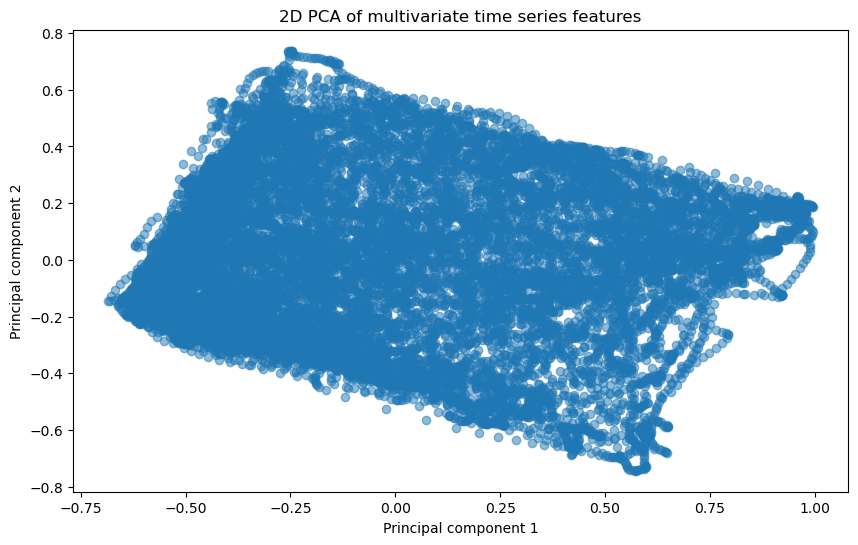

In [23]:
plt.figure(figsize=(10, 6))
sc = plt.scatter(mts_pca_2d[:, 0], mts_pca_2d[:, 1], alpha=0.5)
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')
plt.title('2D PCA of multivariate time series features')

# NOTE: Not working...
cursor = mplcursors.cursor(sc, hover=True)
cursor.connect("add", lambda sel: sel.annotation.set_text(f"ID: {sel.index}"))

plt.show()

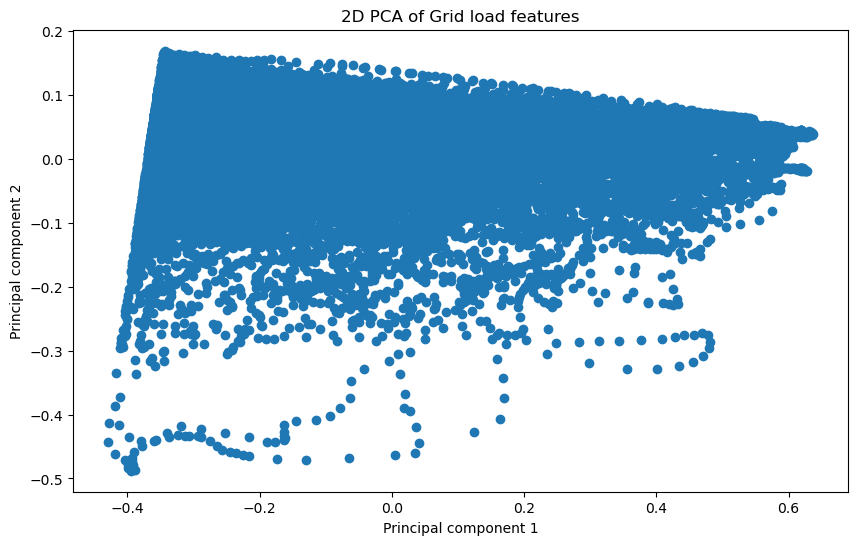

In [17]:
ts1_features_reshape = mts_features_reshape[:,0:4]

pca_2d = PCA(n_components=2)
ts1_pca_2d = pca_2d.fit_transform(ts1_features_reshape)

plt.figure(figsize=(10, 6))
plt.scatter(ts1_pca_2d[:, 0], ts1_pca_2d[:, 1])
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')
plt.title('2D PCA of Grid load features')
plt.show()

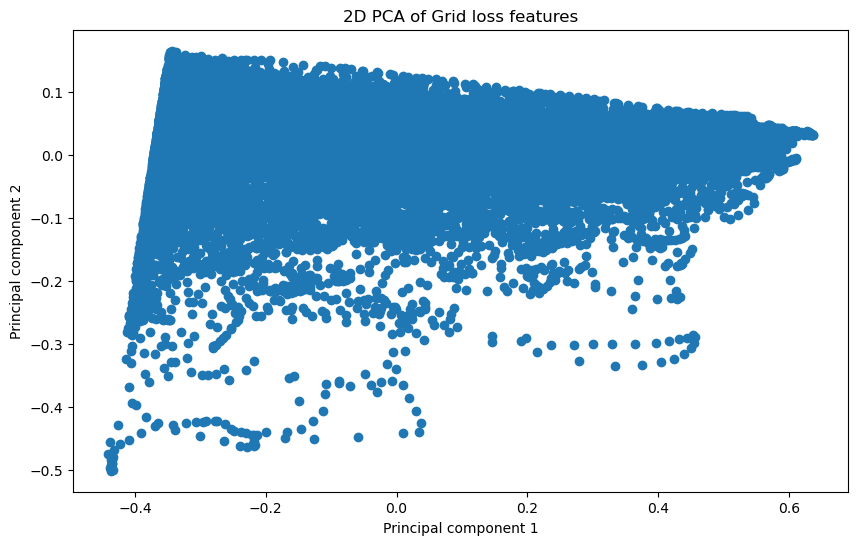

In [18]:
ts2_features_reshape = mts_features_reshape[:,4:8]

pca_2d = PCA(n_components=2)
ts2_pca_2d = pca_2d.fit_transform(ts2_features_reshape)

plt.figure(figsize=(10, 6))
plt.scatter(ts2_pca_2d[:, 0], ts2_pca_2d[:, 1])
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')
plt.title('2D PCA of Grid loss features')
plt.show()

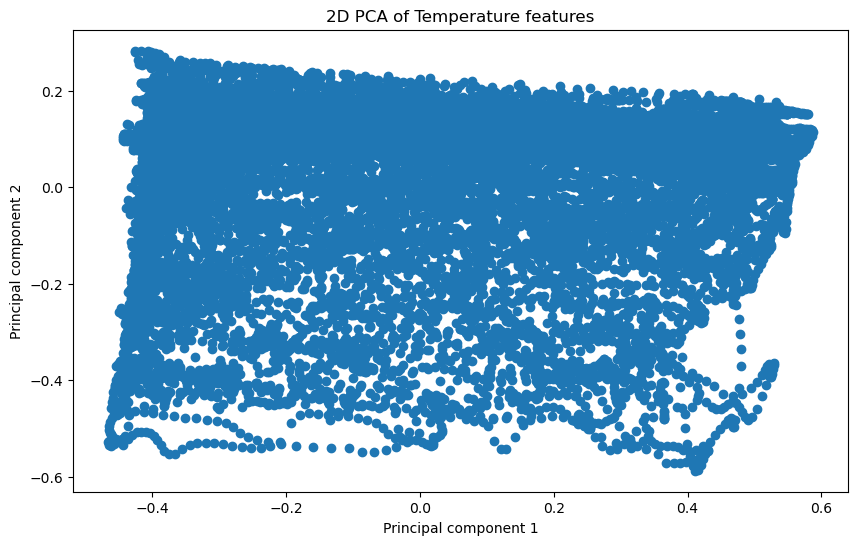

In [19]:
ts3_features_reshape = mts_features_reshape[:,8:12]

pca_2d = PCA(n_components=2)
ts3_pca_2d = pca_2d.fit_transform(ts3_features_reshape)

plt.figure(figsize=(10, 6))
plt.scatter(ts3_pca_2d[:, 0], ts3_pca_2d[:, 1])
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')
plt.title('2D PCA of Temperature features')
plt.show()